In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

import json
from pytorch3dunet.unet3d import model

import torch
from torch.utils.data import DataLoader

from datetime import datetime

import torchmetrics

from train_utils import train, plot_losses, predictions, LoadData

c:\Users\Caroline\anaconda3\envs\Master_Caroline\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


This is a script that trains a set of 3D-UNet models on Looping Star k-space data for reconstruction to image space.

UNet implementation is borrowed from Adrian Wolney on https://github.com/wolny/pytorch-3dunet 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.set_default_dtype(torch.float32) 

Device: cuda


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Defining paths to training and validation data

In [5]:
train_img_path = '../Preprocessing/preprocessed_img_train'
train_kspace_path = '../Preprocessing/preprocessed_kspace_train'

val_img_path = '../Preprocessing/preprocessed_img_val'
val_kspace_path = '../Preprocessing/preprocessed_kspace_val'

In [6]:
train_data = LoadData(train_kspace_path, train_img_path, datatype='train')
val_data = LoadData(val_kspace_path, val_img_path, datatype='val')

### Defining loss function

A combination of Mean Absolute Error (MAE) and Structural Similarity Index (SSIM) was used as a loss function. Weighted with 0.84*MAE and (1-0.84) x SSIM.

In [7]:
ssim = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=1).to(device=device)

def SSIM_loss(pred, true):
    ssim_value = ssim(pred, true)
    return 1. - ssim_value

def MAE_SSIM_loss(pred, true):
    true = true.squeeze(1)
    ssim_loss = SSIM_loss(pred, true)
    mae_loss_fn = torch.nn.L1Loss()
    mae_loss = mae_loss_fn(pred, true)
    weight = 0.84
    combined_loss = (1-weight)*ssim_loss + weight*mae_loss
    return combined_loss*100

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    """ 
    Saving checkpoints during training. 
    Parameters: 
    - model: Model to be saved 
    - optimizer: Optimizer to be saved
    - epoch: The current number of epoch running
    - loss: The current loss value (validation loss)
    - filename: Filename to be saved as

    Returns: 
    None.
    """

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)

## Model training

Different combinations of learning rates, weight decays, and dropout values were tested over 30 training epochs. For each epoch, model weights and predicted outputs were saved. After training, the training loss, validation loss, and corresponding hyperparameter configuration were saved as well. The loss function used was a combination of Mean Absolute Error (MAE) and Structural Similarity Index (SSIM), optimized using the Adam optimizer.

Due to computational constraints and long training times (each model took on average 21 hours to train), only a limited number of hyperparameter combinations could be tested in a single session. Running more than three training instances sequentially often caused the system to shut down, and therefore, only a subset of the tested combinations is shown below. Specifically, the results for all learning rates with fixed weight decay of 1e-3 and dropout of 0.3. 

Testing hyperparameters: learning rate = 0.0005, weight decay = 0.001, drop out = 0.3


C:\Users\Caroline\AppData\Local\Temp\ipykernel_7976\3755693864.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
C:\Users\Caroline\AppData\

 Epoch 1: Training loss 11.225561018828508 13:39:14.413313 
 Epoch 1: Validation loss 10.421260742040781 13:39:14.413313 


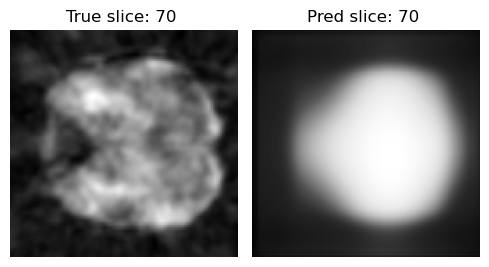

 Epoch 2: Training loss 9.679735538723705 14:14:05.661053 
 Epoch 2: Validation loss 9.454766035079956 14:14:05.661053 


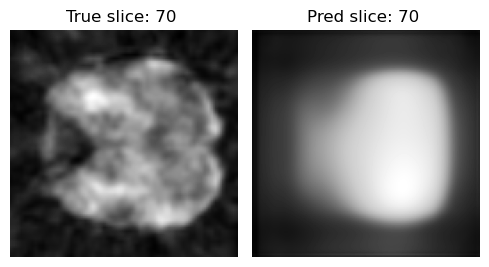

 Epoch 3: Training loss 9.134571211678642 14:48:57.043425 
 Epoch 3: Validation loss 9.53997327731206 14:48:57.043425 


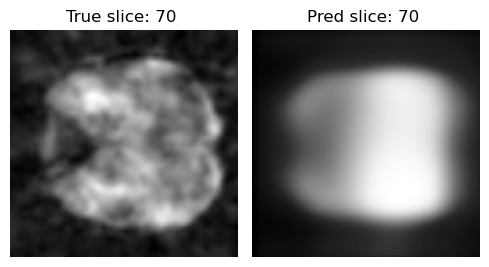

 Epoch 4: Training loss 8.794607729702205 15:23:49.090341 
 Epoch 4: Validation loss 9.87144217124352 15:23:49.090341 


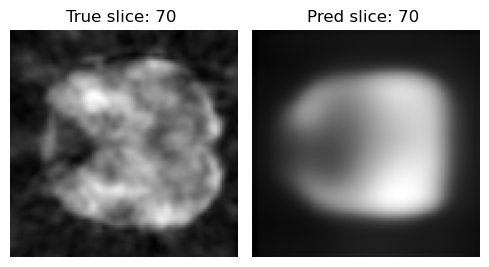

 Epoch 5: Training loss 8.379578096526009 15:58:39.443386 
 Epoch 5: Validation loss 9.47901674417349 15:58:39.443386 


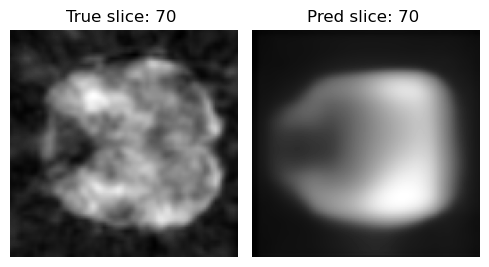

 Epoch 6: Training loss 7.87449002789927 16:33:41.090517 
 Epoch 6: Validation loss 9.39096450805664 16:33:41.090517 


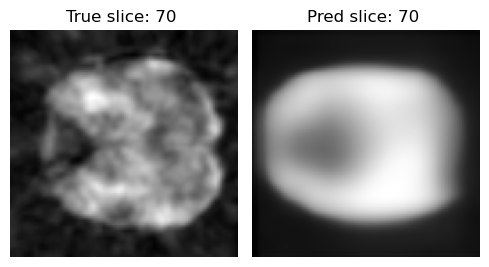

 Epoch 7: Training loss 7.52320402271145 17:08:33.924923 
 Epoch 7: Validation loss 9.28523822931143 17:08:33.924923 


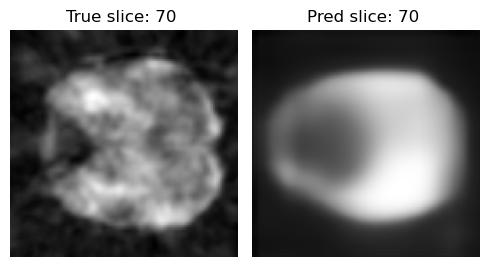

 Epoch 8: Training loss 7.12216670696552 17:43:23.740845 
 Epoch 8: Validation loss 9.530088846500103 17:43:23.740845 


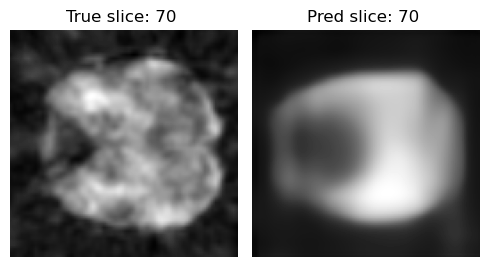

 Epoch 9: Training loss 6.892556696147709 18:18:14.096637 
 Epoch 9: Validation loss 9.71179485321045 18:18:14.096637 


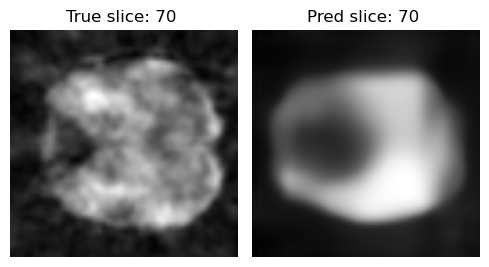

 Epoch 10: Training loss 6.461768125439738 18:53:02.832264 
 Epoch 10: Validation loss 9.694131631117601 18:53:02.832264 


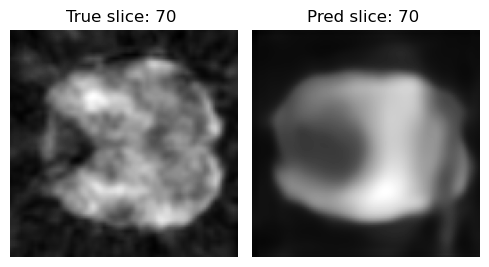

 Epoch 11: Training loss 5.884927027828091 19:27:54.052661 
 Epoch 11: Validation loss 9.979526281356812 19:27:54.052661 


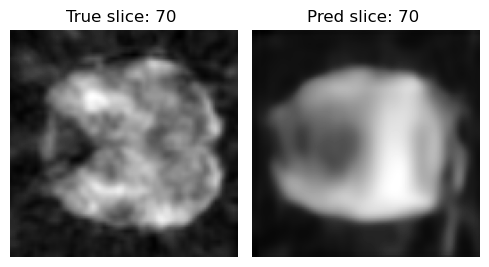

 Epoch 12: Training loss 4.689021285418626 20:02:45.042179 
 Epoch 12: Validation loss 10.60779725588285 20:02:45.042179 


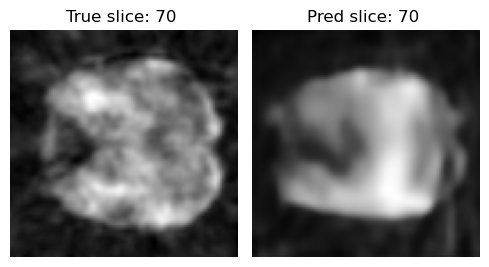

 Epoch 13: Training loss 3.892991761584858 20:37:34.637465 
 Epoch 13: Validation loss 10.758706991489117 20:37:34.637465 


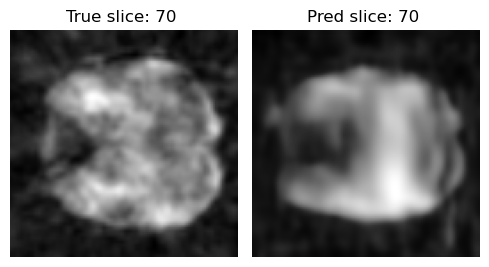

 Epoch 14: Training loss 3.036122285402738 21:12:25.143907 
 Epoch 14: Validation loss 10.828966856002808 21:12:25.143907 


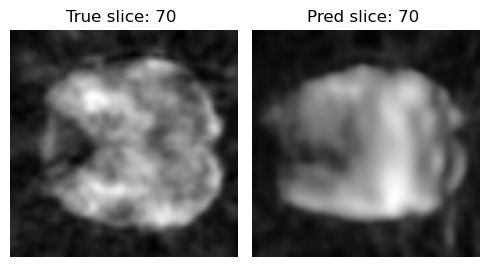

 Epoch 15: Training loss 2.572521672799037 21:47:16.919457 
 Epoch 15: Validation loss 11.132968040613028 21:47:16.919457 


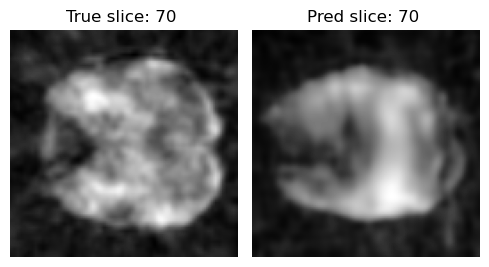

 Epoch 16: Training loss 2.1797229575586843 22:22:06.870051 
 Epoch 16: Validation loss 11.290245019472563 22:22:06.871089 


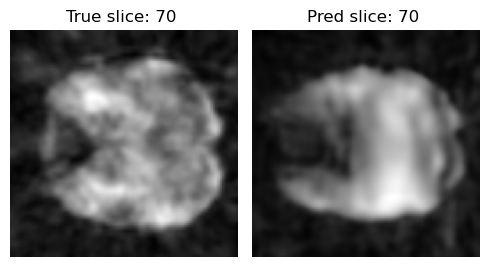

 Epoch 17: Training loss 1.8680723368466556 23:07:20.339112 
 Epoch 17: Validation loss 11.281720913373507 23:07:20.339112 


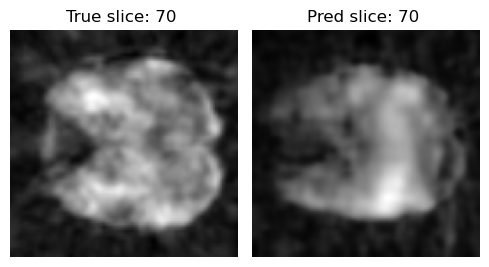

 Epoch 18: Training loss 1.8957475836460407 23:42:09.416515 
 Epoch 18: Validation loss 10.963882758067204 23:42:09.416515 


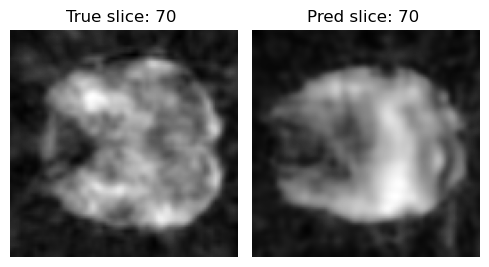

 Epoch 19: Training loss 1.5766092240810394 00:27:25.305942 
 Epoch 19: Validation loss 11.260289192199707 00:27:25.305942 


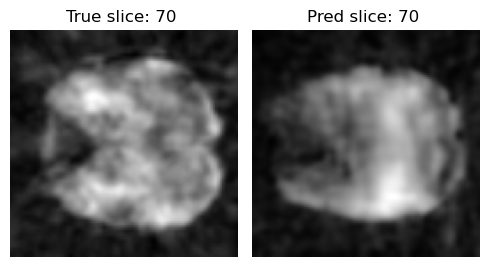

 Epoch 20: Training loss 1.729481164243195 01:02:19.201106 
 Epoch 20: Validation loss 11.225357605860783 01:02:19.201106 


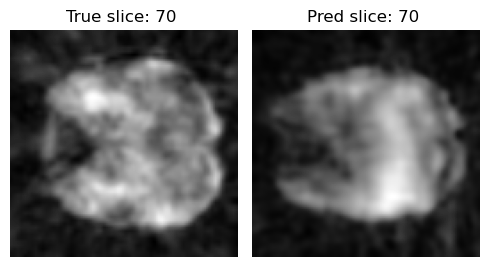

 Epoch 21: Training loss 1.4896097551662844 01:47:30.226783 
 Epoch 21: Validation loss 11.256379164182222 01:47:30.226783 


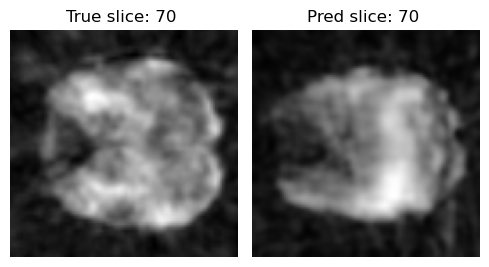

 Epoch 22: Training loss 1.4241564301671563 02:32:43.440545 
 Epoch 22: Validation loss 11.177569187604464 02:32:43.440545 


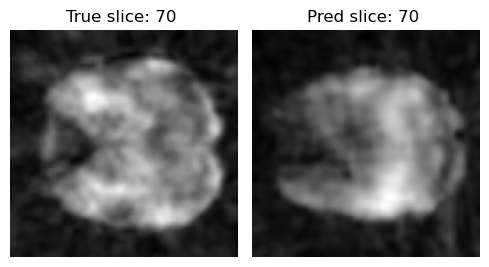

 Epoch 23: Training loss 1.5147158379083152 03:17:55.548049 
 Epoch 23: Validation loss 11.022540459266075 03:17:55.548049 


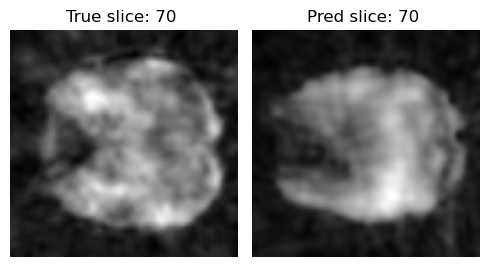

 Epoch 24: Training loss 5.460067855296554 03:52:46.458200 
 Epoch 24: Validation loss 10.505417255254892 03:52:46.458200 


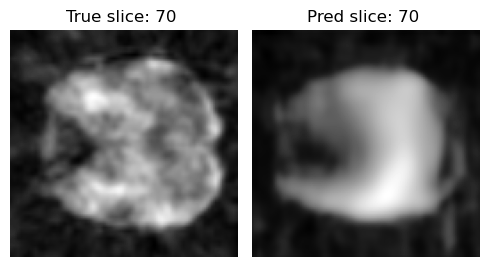

 Epoch 25: Training loss 2.3266370591226515 04:27:37.643862 
 Epoch 25: Validation loss 11.383092183333178 04:27:37.643862 


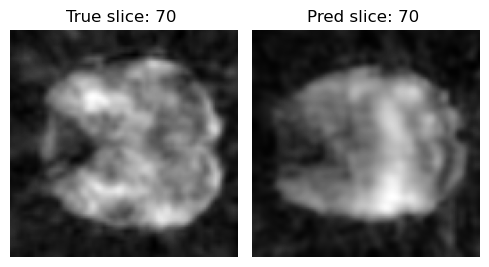

 Epoch 26: Training loss 1.3752951407498055 05:02:28.265645 
 Epoch 26: Validation loss 11.096770213200497 05:02:28.265645 


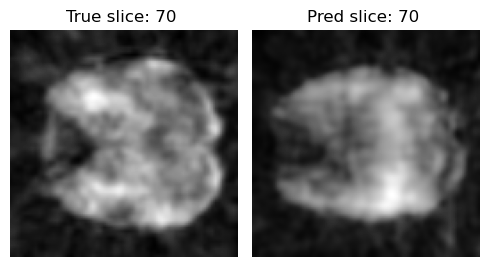

 Epoch 27: Training loss 1.3108020565666996 05:37:19.857959 
 Epoch 27: Validation loss 11.180888120944683 05:37:19.857959 


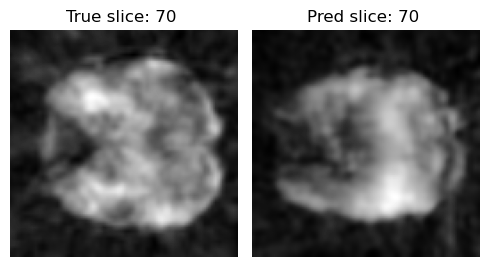

 Epoch 28: Training loss 1.523199947980734 06:12:15.740743 
 Epoch 28: Validation loss 11.110252417050875 06:12:15.740743 


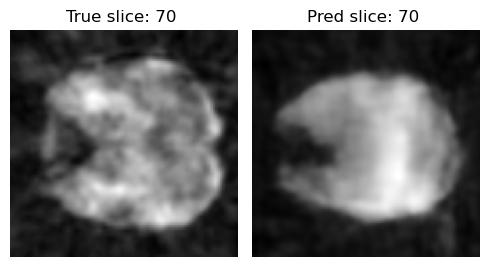

 Epoch 29: Training loss 1.5693441126700287 06:47:07.970517 
 Epoch 29: Validation loss 11.23532797740056 06:47:07.970517 


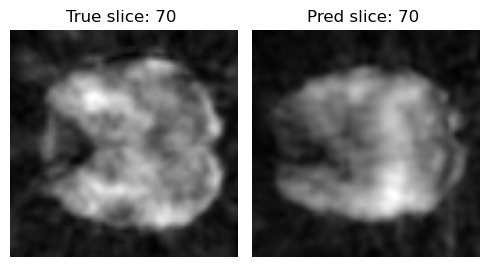

 Epoch 30: Training loss 1.2136866520721834 07:22:00.329306 
 Epoch 30: Validation loss 11.32459618495061 07:22:00.329306 


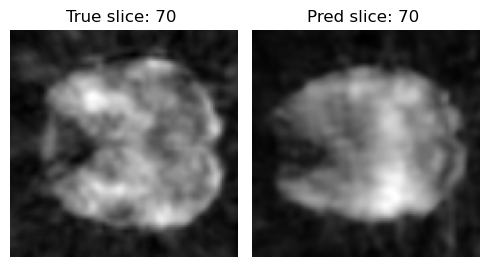

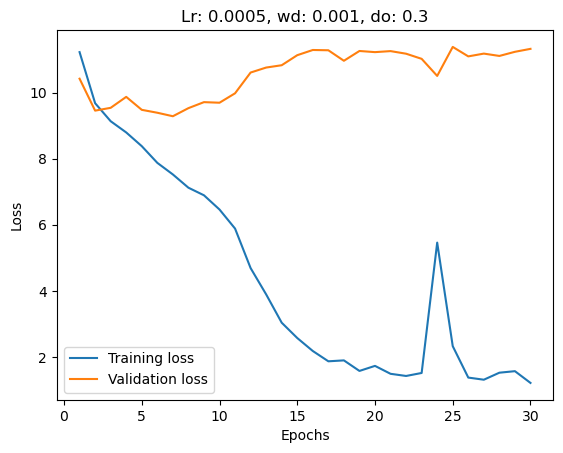

Testing hyperparameters: learning rate = 0.001, weight decay = 0.001, drop out = 0.3
 Epoch 1: Training loss 11.338769236763754 07:56:52.202651 
 Epoch 1: Validation loss 11.012586758686947 07:56:52.203688 


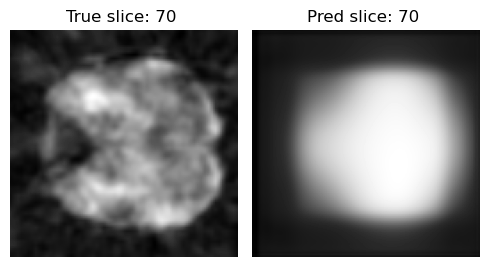

 Epoch 2: Training loss 10.045681683571784 08:31:45.111326 
 Epoch 2: Validation loss 10.44626784324646 08:31:45.111326 


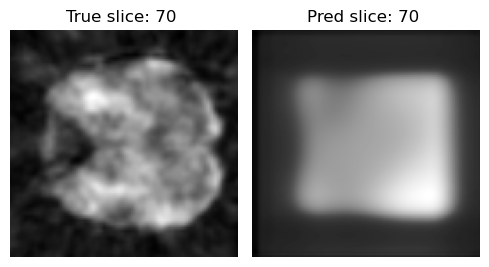

 Epoch 3: Training loss 9.250857499929575 09:06:37.712758 
 Epoch 3: Validation loss 9.516519766587477 09:06:37.712758 


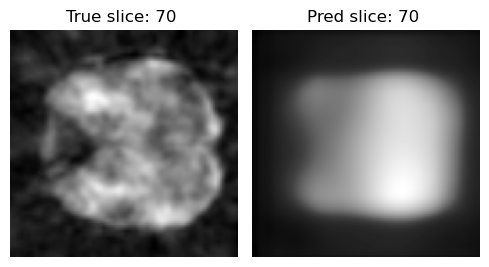

 Epoch 4: Training loss 8.756371393308534 09:41:27.928198 
 Epoch 4: Validation loss 9.541747808456421 09:41:27.928198 


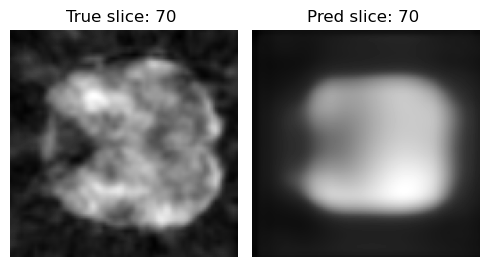

 Epoch 5: Training loss 8.273088839027908 10:16:20.135032 
 Epoch 5: Validation loss 10.086274403792162 10:16:20.136069 


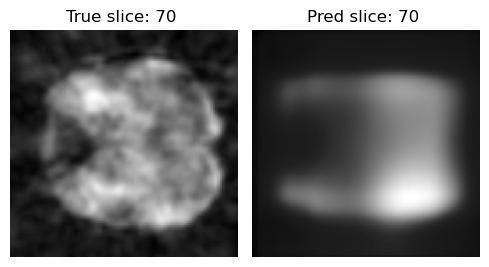

 Epoch 6: Training loss 7.910529622664819 10:51:13.349442 
 Epoch 6: Validation loss 9.525803235860971 10:51:13.349442 


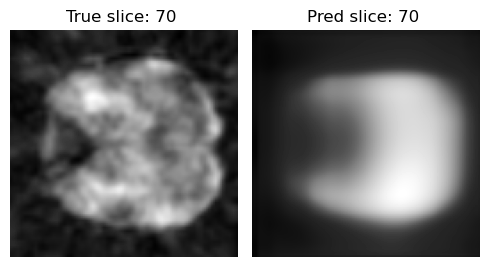

 Epoch 7: Training loss 7.513611912727356 11:36:35.392777 
 Epoch 7: Validation loss 9.706119317274828 11:36:35.392777 


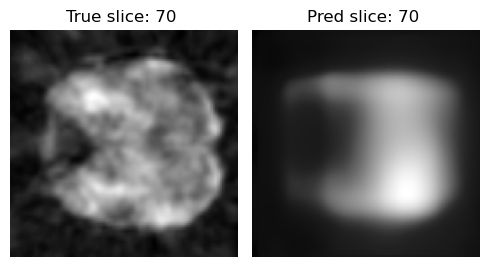

 Epoch 8: Training loss 7.253302089460603 12:11:29.137776 
 Epoch 8: Validation loss 9.765518463574923 12:11:29.137776 


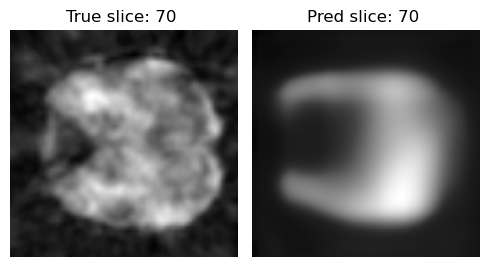

 Epoch 9: Training loss 7.050868054012676 12:46:37.723490 
 Epoch 9: Validation loss 9.699273311174833 12:46:37.723490 


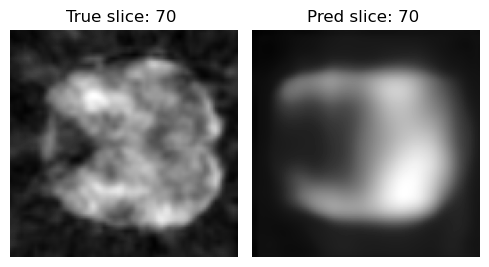

 Epoch 10: Training loss 6.79422763808743 13:21:31.189382 
 Epoch 10: Validation loss 9.667358618516188 13:21:31.189382 


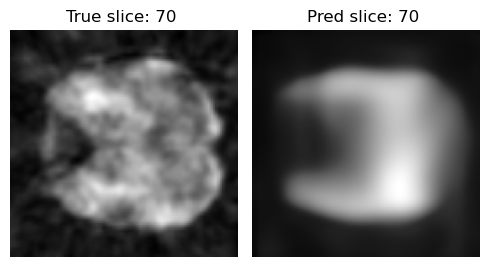

 Epoch 11: Training loss 6.58781345466991 14:06:46.764256 
 Epoch 11: Validation loss 10.045083284378052 14:06:46.764256 


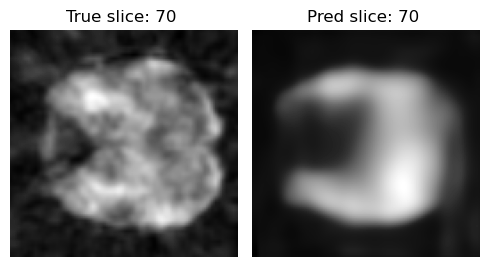

 Epoch 12: Training loss 5.981729633205539 14:41:38.173875 
 Epoch 12: Validation loss 9.916812878388624 14:41:38.173875 


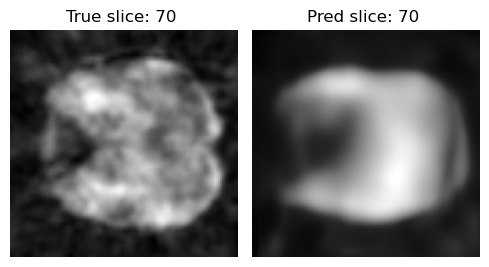

 Epoch 13: Training loss 5.381433507898351 15:26:52.625822 
 Epoch 13: Validation loss 10.336881655913134 15:26:52.625822 


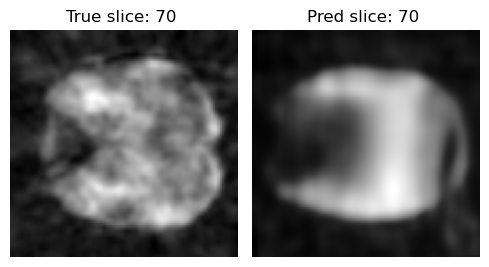

 Epoch 14: Training loss 4.30766763660934 16:12:05.969397 
 Epoch 14: Validation loss 10.129072537788979 16:12:05.969397 


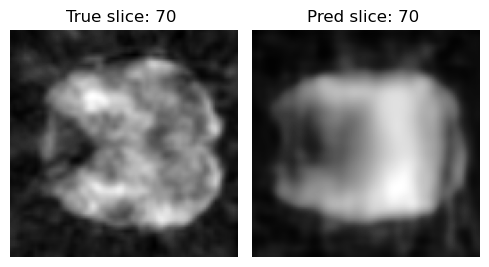

 Epoch 15: Training loss 3.690913730925256 16:57:34.317746 
 Epoch 15: Validation loss 10.704298239487867 16:57:34.317746 


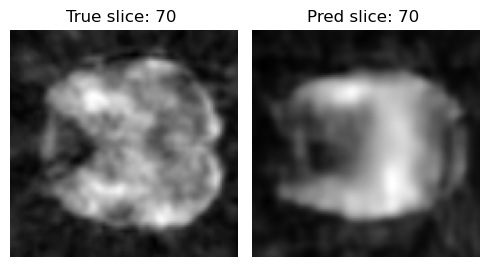

 Epoch 16: Training loss 2.9688573679426216 17:42:47.399644 
 Epoch 16: Validation loss 10.934369600736177 17:42:47.399644 


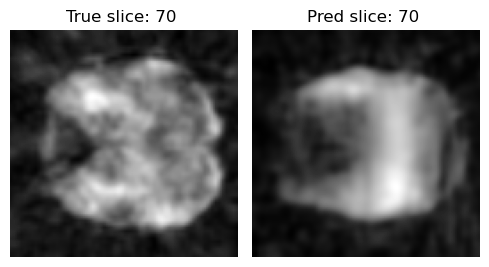

 Epoch 17: Training loss 2.408910327887797 18:28:00.757807 
 Epoch 17: Validation loss 10.480837528522198 18:28:00.757807 


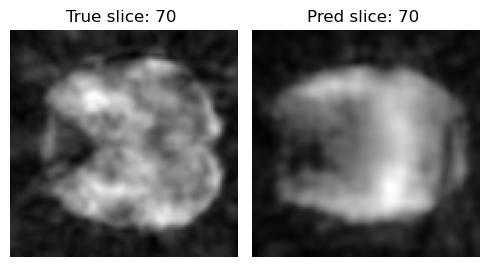

 Epoch 18: Training loss 2.4223734160046 19:13:13.288659 
 Epoch 18: Validation loss 10.656784057617188 19:13:13.288659 


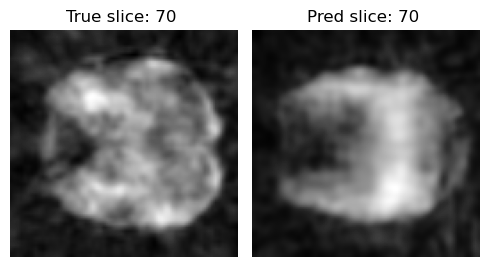

 Epoch 19: Training loss 2.087706886477523 19:58:27.154350 
 Epoch 19: Validation loss 11.054506852076603 19:58:27.154350 


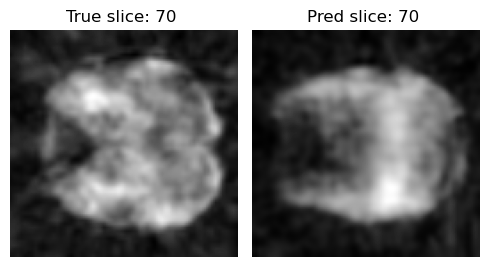

 Epoch 20: Training loss 1.8729581096015133 20:43:40.293667 
 Epoch 20: Validation loss 11.010291741444515 20:43:40.293667 


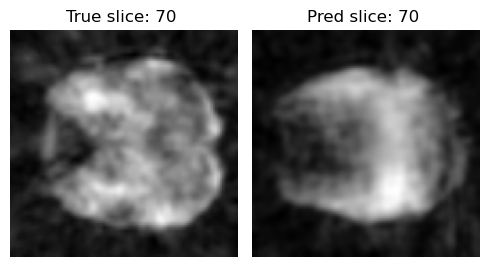

 Epoch 21: Training loss 1.9688788796519185 21:28:54.400758 
 Epoch 21: Validation loss 10.79744003369258 21:28:54.400758 


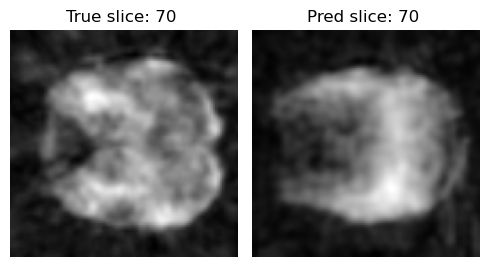

 Epoch 22: Training loss 2.010290416387411 22:14:08.831858 
 Epoch 22: Validation loss 10.78194053356464 22:14:08.831858 


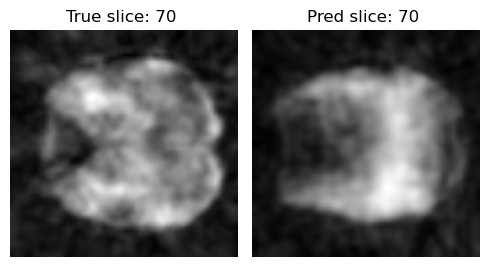

 Epoch 23: Training loss 1.7042490227536842 22:59:21.965050 
 Epoch 23: Validation loss 10.89194890168997 22:59:21.965050 


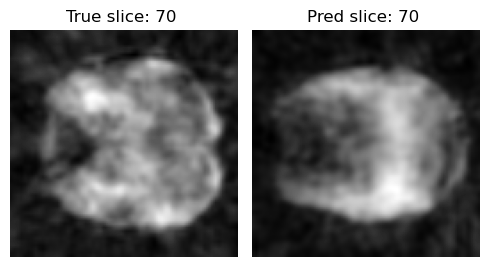

 Epoch 24: Training loss 1.6800712042457455 23:44:36.972581 
 Epoch 24: Validation loss 10.90444040298462 23:44:36.972581 


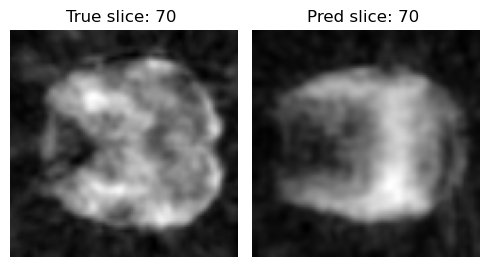

 Epoch 25: Training loss 1.9647774941973635 00:29:50.724137 
 Epoch 25: Validation loss 11.091414488278902 00:29:50.725161 


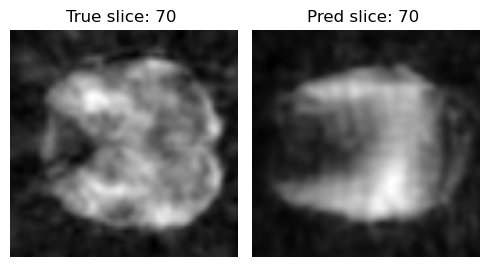

 Epoch 26: Training loss 2.0130903681555945 01:15:09.953593 
 Epoch 26: Validation loss 10.963534611922045 01:15:09.953593 


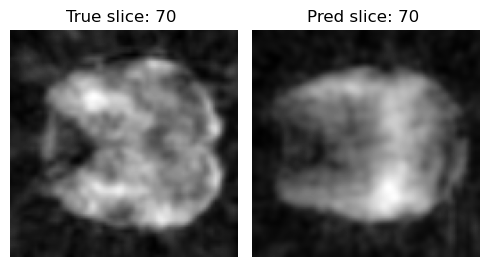

 Epoch 27: Training loss 1.5532074231695343 02:00:27.114983 
 Epoch 27: Validation loss 10.891468653312096 02:00:27.114983 


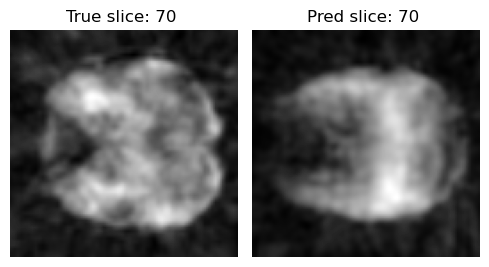

 Epoch 28: Training loss 1.5489219443483666 02:45:42.597629 
 Epoch 28: Validation loss 11.002863370455229 02:45:42.597629 


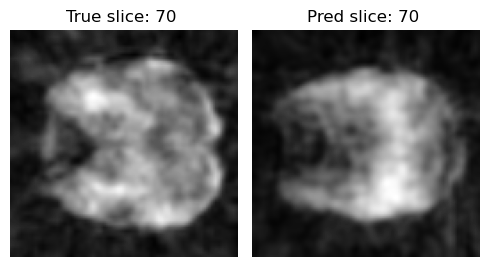

 Epoch 29: Training loss 1.5744355134256593 03:30:55.831458 
 Epoch 29: Validation loss 10.914624984447773 03:30:55.831458 


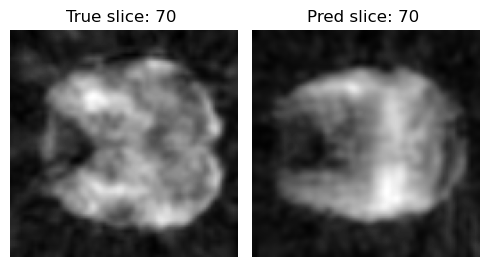

 Epoch 30: Training loss 2.642107131716969 04:16:10.333015 
 Epoch 30: Validation loss 10.698748606901903 04:16:10.333015 


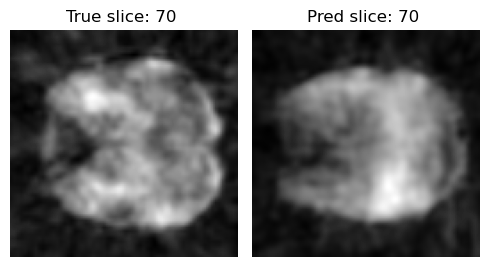

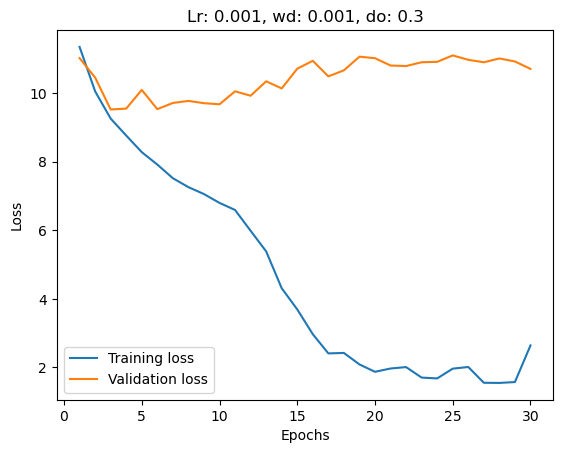

Testing hyperparameters: learning rate = 0.005, weight decay = 0.001, drop out = 0.3
 Epoch 1: Training loss 13.784725917564643 04:51:04.059034 
 Epoch 1: Validation loss 11.490188066775982 04:51:04.059034 


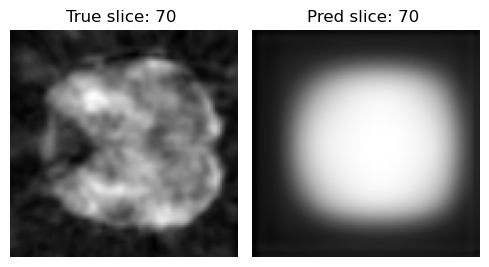

 Epoch 2: Training loss 10.242442214881981 05:36:23.217323 
 Epoch 2: Validation loss 10.520090983464168 05:36:23.217323 


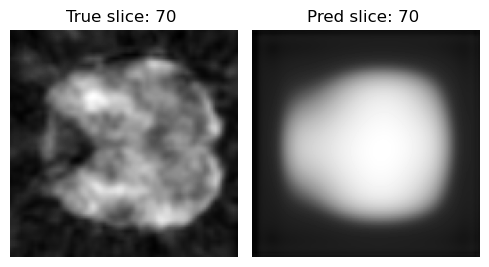

 Epoch 3: Training loss 10.167132375004527 06:21:38.608504 
 Epoch 3: Validation loss 9.791873620106625 06:21:38.608504 


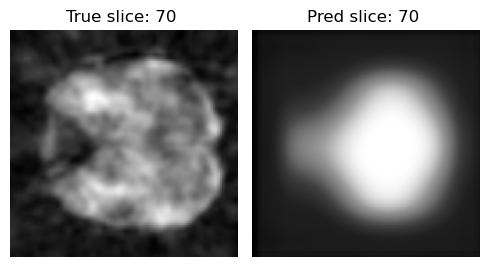

 Epoch 4: Training loss 10.266195268421383 07:06:53.015556 
 Epoch 4: Validation loss 10.533105061604427 07:06:53.015556 


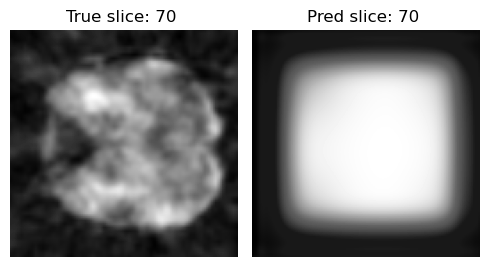

 Epoch 5: Training loss 9.983784080861689 07:41:46.160034 
 Epoch 5: Validation loss 9.992353567710289 07:41:46.160034 


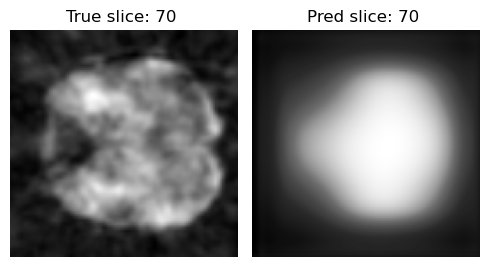

 Epoch 6: Training loss 10.26231822338733 08:27:01.078415 
 Epoch 6: Validation loss 10.92200310413654 08:27:01.078415 


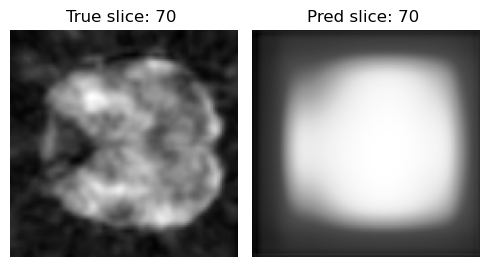

 Epoch 7: Training loss 10.372953328457507 09:01:53.552314 
 Epoch 7: Validation loss 10.050077309975258 09:01:53.552314 


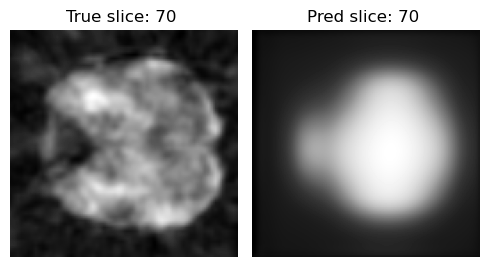

 Epoch 8: Training loss 9.944892550562765 09:47:09.539531 
 Epoch 8: Validation loss 11.922689199447632 09:47:09.539531 


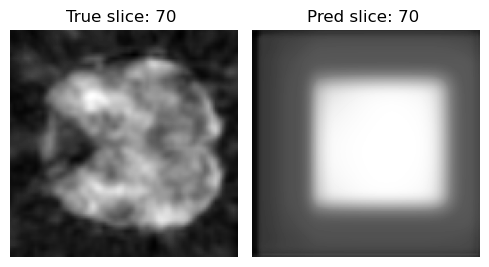

 Epoch 9: Training loss 10.724323940801096 10:32:27.621424 
 Epoch 9: Validation loss 11.893760002576387 10:32:27.622429 


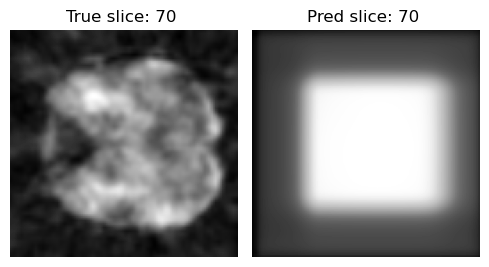

 Epoch 10: Training loss 10.35592832670107 11:17:50.268630 
 Epoch 10: Validation loss 10.154422154793373 11:17:50.268630 


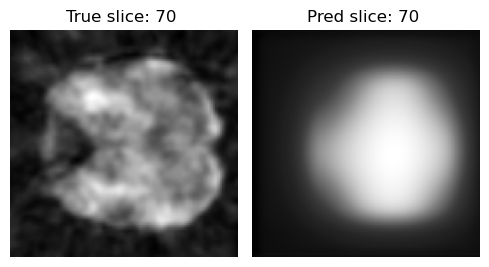

 Epoch 11: Training loss 10.287116679516467 12:03:09.873424 
 Epoch 11: Validation loss 10.24822785304143 12:03:09.873424 


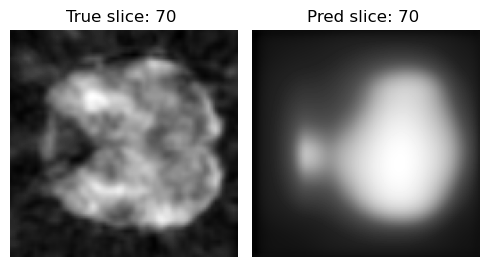

 Epoch 12: Training loss 9.752966210082336 12:48:30.019229 
 Epoch 12: Validation loss 10.054332861533531 12:48:30.019229 


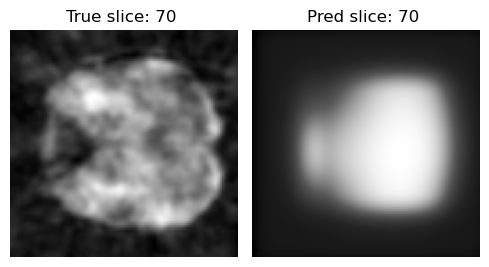

 Epoch 13: Training loss 10.29654952457973 13:33:55.255422 
 Epoch 13: Validation loss 9.950035296953642 13:33:55.255422 


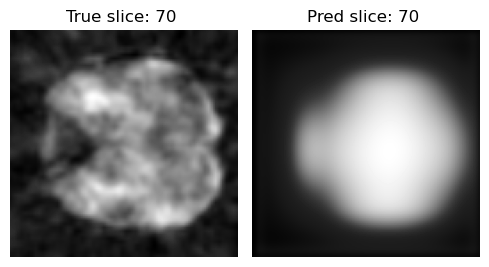

 Epoch 14: Training loss 10.572501462894481 14:19:17.294680 
 Epoch 14: Validation loss 10.656942422573383 14:19:17.294680 


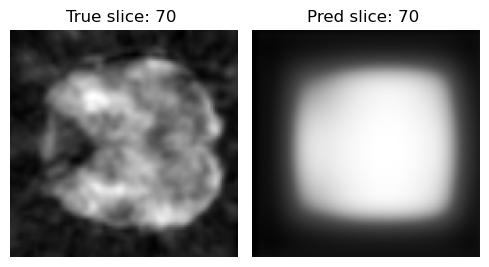

 Epoch 15: Training loss 9.889939585884848 15:04:34.616947 
 Epoch 15: Validation loss 11.70823828990643 15:04:34.616947 


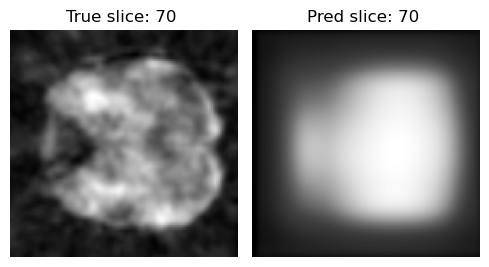

 Epoch 16: Training loss 9.756104034381908 15:49:53.270851 
 Epoch 16: Validation loss 9.951076654287485 15:49:53.270851 


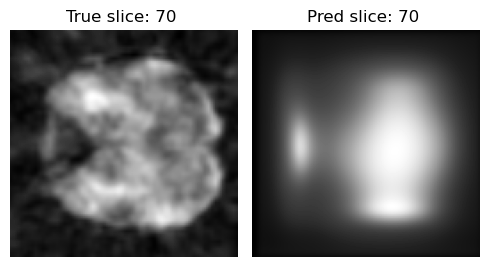

 Epoch 17: Training loss 9.658575747039292 16:35:11.601987 
 Epoch 17: Validation loss 9.622560115960928 16:35:11.603013 


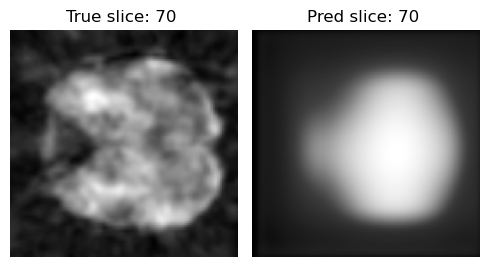

 Epoch 18: Training loss 10.608780418123517 17:20:46.105112 
 Epoch 18: Validation loss 12.884887988750751 17:20:46.105112 


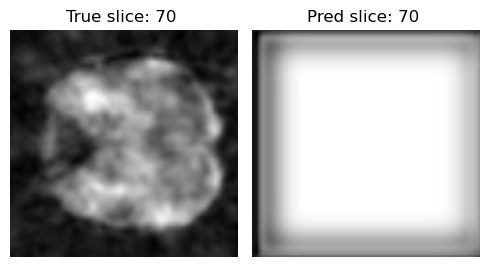

 Epoch 19: Training loss 11.43869426224258 18:06:06.144782 
 Epoch 19: Validation loss 13.918321169339693 18:06:06.144782 


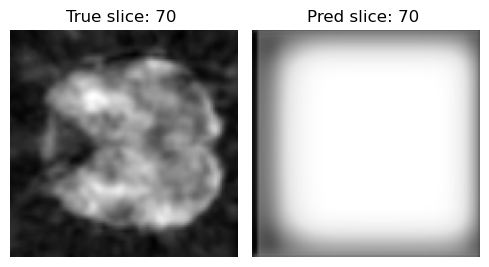

 Epoch 20: Training loss 10.800396599612393 18:51:34.807475 
 Epoch 20: Validation loss 11.44504059278048 18:51:34.807475 


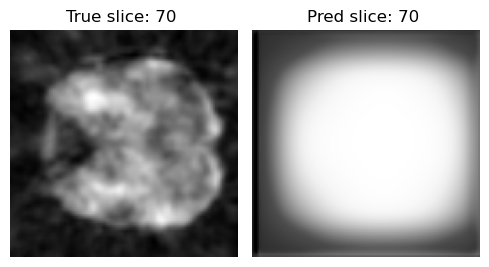

 Epoch 21: Training loss 10.089717608231764 19:36:56.670258 
 Epoch 21: Validation loss 9.616927587068998 19:36:56.670258 


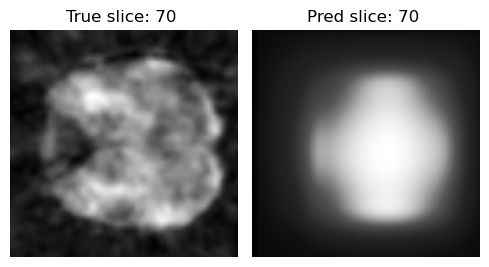

 Epoch 22: Training loss 9.68430147590218 20:22:18.497138 
 Epoch 22: Validation loss 11.026336853320782 20:22:18.497138 


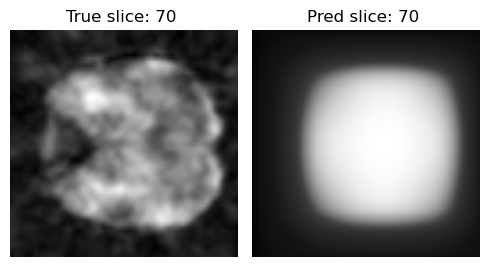

 Epoch 23: Training loss 9.772251920385676 21:07:38.553983 
 Epoch 23: Validation loss 10.626999873381395 21:07:38.553983 


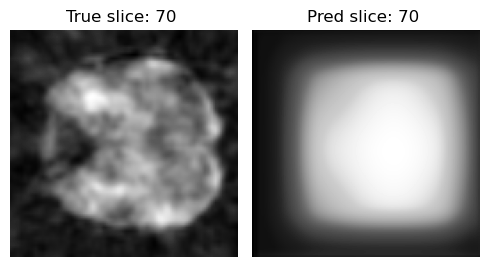

 Epoch 24: Training loss 9.902797193317623 21:52:59.135806 
 Epoch 24: Validation loss 9.851625240766085 21:52:59.135806 


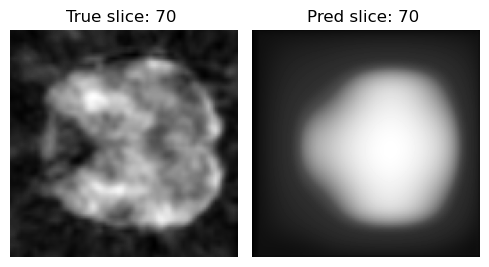

 Epoch 25: Training loss 9.727146714598268 22:38:19.990185 
 Epoch 25: Validation loss 10.67269229888916 22:38:19.990185 


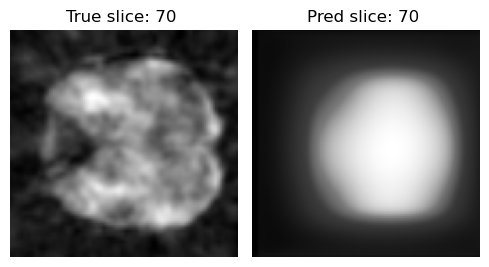

 Epoch 26: Training loss 9.692761874460912 23:23:39.953535 
 Epoch 26: Validation loss 10.864989775877733 23:23:39.953535 


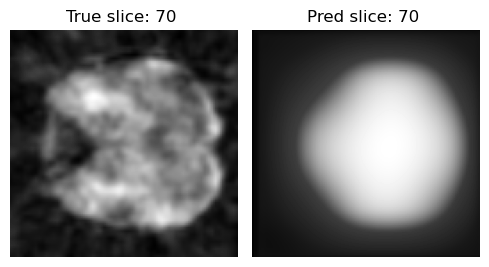

 Epoch 27: Training loss 9.595368031617049 00:08:59.860576 
 Epoch 27: Validation loss 10.748062463907095 00:08:59.860576 


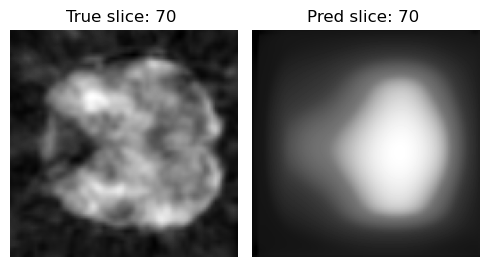

 Epoch 28: Training loss 9.201896494561499 00:54:20.081403 
 Epoch 28: Validation loss 11.952773277576153 00:54:20.081403 


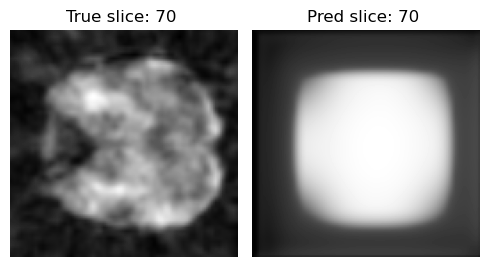

 Epoch 29: Training loss 10.45333264686249 01:39:42.803488 
 Epoch 29: Validation loss 10.026638544522799 01:39:42.803488 


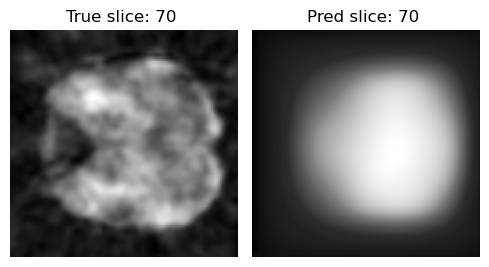

 Epoch 30: Training loss 9.851041780723321 02:25:07.468503 
 Epoch 30: Validation loss 11.537262696486254 02:25:07.468503 


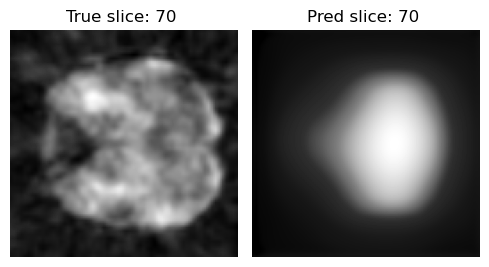

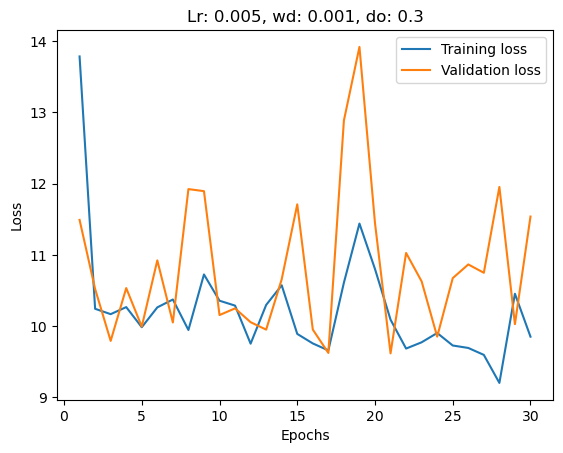

In [ ]:
results = [] 

# Hyperparameter combinations to try
learning_rates = [5e-4, 1e-3, 5e-3] 
weight_decays = [1e-3, 1e-2] 
drop_outs = [0.3, 0.4]

# Looping through different hyperparameter combinations
for drop_out in drop_outs:
    for lr in learning_rates:
        for wd in weight_decays:

            print(f"Testing hyperparameters: learning rate = {lr}, weight decay = {wd}, drop out = {drop_out}")
            
            # Set seed and initialize the data loaders
            set_seed(42)
            batch_size = 1
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))

            # Initialize the model
            Unet3D = model.UNet3D(in_channels=2, out_channels=1, num_groups=8, is_segmentation=False, dropout_prob=drop_out)
            Unet3D.to(device=device)


            # Initialize optimizer and loss function
            optimizer = torch.optim.Adam(Unet3D.parameters(), lr=lr, weight_decay=wd)
            loss_fn = MAE_SSIM_loss
            
            n_epochs = 30
            
            train_loss, val_loss = [], []  # To store loss values for each epoch

            for epoch in range(1, n_epochs+1):
                train_epoch_loss, val_epoch_loss = train(optimizer, Unet3D, loss_fn, train_loader, val_loader)
                train_loss.append(train_epoch_loss)
                val_loss.append(val_epoch_loss)

                print(f' Epoch {epoch}: Training loss {train_epoch_loss} {datetime.now().time()} ')
                if val_loader != None:
                    print(f' Epoch {epoch}: Validation loss {val_epoch_loss} {datetime.now().time()} ')

                # Get the predictions to plot
                preds, true = predictions(Unet3D, val_loader)

                # Only selecting the first time point and moving tensors to CPU
                preds_cpu = preds[0].cpu()
                true_cpu = true[0].cpu()

                # Removing batch and channel dimension
                preds_squeezed = preds_cpu.squeeze(0,1)
                true_squeezed = true_cpu.squeeze(0,1)


                fig, axes = plt.subplots(1, 2, figsize=(5,3))

                # Plotting slice 70 in the z-dimension
                i = 70
                pred_sliced = preds_squeezed[:,:,i]
                true_sliced = true_squeezed[:,:,i]

                axes[0].imshow(true_sliced, cmap='gray')
                axes[0].set_title(f'True slice: {i} ')
                axes[0].axis('off')

                axes[1].imshow(pred_sliced, cmap='gray')
                axes[1].set_title(f'Pred slice: {i} ')
                axes[1].axis('off')

                plt.tight_layout()
                plt.show()

                # Saving the image
                plt_savename = f'./3D_model_weights/img_lr{lr}_epoch{epoch}_do{drop_out}_wd{wd}.png'
                fig.savefig(plt_savename)

                # Saving the model's state_dict to a file
                filename = f'./3D_model_weights/model_lr{lr}_wd{wd}_do{drop_out}_epoch{epoch}.pth'
                save_checkpoint(Unet3D, optimizer, epoch, val_epoch_loss, filename=filename)

                result = {
                    'learning rate': lr,
                    'weight decay': wd,
                    'drop out': drop_out,
                    'epoch': epoch,
                    'loss' : val_epoch_loss
                    }
                results.append(result)

            # Plotting the training and validation loss
            plot_losses(train_loss, val_loss, len(train_loss))


            # Saving the training and validation loss
            val_loss_list_filename = f'./3D_model_weights/val_loss_model_lr{lr}_wd{wd}_do0.3.json'
            train_loss_list_filename = f'./3D_model_weights/train_loss_model_lr{lr}_wd{wd}_do0.3.json'

            with open(val_loss_list_filename, "w") as val_loss_file:
                json.dump(val_loss, val_loss_file)

            with open(train_loss_list_filename, "w") as train_loss_file:
                json.dump(train_loss, train_loss_file)

            plt.title(f'Lr: {lr}, wd: {wd}, do: {drop_out}')
            
            plt.show()


# Saving the results
with open("./3D_model_weights/TEST_results_wd1e-3_lr_all_do0.3.json", "w") as file:
    json.dump(results, file)